#### Install required libraries


In [1]:
! pip uninstall gpboost -y
! pip uninstall zoish -y
! pip install git+https://github.com/TorkamaniLab/zoish.git
! pip install feature-engine category-encoders scikit-learn ipywidgets numpy pandas xgboost --force-reinstall

Found existing installation: zoish 5.0.3
Uninstalling zoish-5.0.3:
  Successfully uninstalled zoish-5.0.3
  Cloning https://github.com/TorkamaniLab/zoish.git to /private/var/folders/v1/xbcjnd1x5rn7ct1m_rnsblk80000gp/T/pip-req-build-c8t5dt49
  Running command git clone --filter=blob:none --quiet https://github.com/TorkamaniLab/zoish.git /private/var/folders/v1/xbcjnd1x5rn7ct1m_rnsblk80000gp/T/pip-req-build-c8t5dt49
  Resolved https://github.com/TorkamaniLab/zoish.git to commit 84fc151991572e317a7649098e4d97f037fa2aee
  Preparing metadata (setup.py) ... done
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl.metadata (22 kB)
Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
  Created wheel for zoish: filename=zoish-5.0.3-py3-none-any.whl size=35020 sha256=7a3f343572791535e5a98884231a6bd04230f5056fae91e033b66fe694156565
  Stored in directory: /private/var/folders/v1/xbcjnd1x5rn7ct1m_rnsblk80000gp/T/pip-ephem-wheel-cache-08btcam5/wheels/3d/b7/56/e1a249a093aec09d57ec81b0bc5d88

In [2]:
# Importing built-in libraries
import pandas as pd  # For data manipulation and analysis
import sys  # For accessing system-specific parameters and functions
import zoish  # Assuming it's a custom library for your project
import sklearn  # For machine learning models
import xgboost  # For gradient-boosted decision trees
import numpy  # For numerical computations

# Importing scikit-learn utilities for various ML tasks
from sklearn.compose import ColumnTransformer  # For applying transformers to columns
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.metrics import (  # For evaluating the model
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, train_test_split  # For CV and splitting dataset
from sklearn.pipeline import Pipeline  # For creating ML pipelines
from sklearn.preprocessing import StandardScaler  # For feature scaling

# Importing other third-party libraries
from category_encoders import TargetEncoder  # For encoding categorical variables
from xgboost import XGBClassifier  # XGBoost classifier
from zoish.feature_selectors.shap_selectors import (  # For feature selection and visualization
    ShapFeatureSelector,
    ShapPlotFeatures,
)
import logging  # For logging events and errors

# Configuring logging settings
from zoish import logger  # Assuming it's a custom logger from zoish
logger.setLevel(logging.ERROR)  # Set logging level to ERROR

# Importing feature imputation library
from feature_engine.imputation import MeanMedianImputer  # For imputing mean/median

# Re-setting logging level (this seems redundant, consider keeping only one)
logger.setLevel(logging.ERROR)

# Printing versions of key libraries for debugging and documentation
print(f'Python version : {sys.version}')
print(f'zoish version : {zoish.__version__}')
print(f'sklearn version : {sklearn.__version__}')
print(f'pandas version : {pd.__version__}')  # Using the alias for pandas
print(f'numpy version : {numpy.__version__}')
print(f'xgboost version : {xgboost.__version__}')


Python version : 3.7.8 (default, Feb 27 2023, 18:11:31) 
[Clang 14.0.0 (clang-1400.0.29.202)]
zoish version : 5.0.3
sklearn version : 1.0.2
pandas version : 1.3.5
numpy version : 1.21.6
xgboost version : 1.6.2


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Example: Audiology (Standardized) Data Set
###### https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29


#### Read data


In [3]:
urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data"
urlname = "https://archive.ics.uci.edu/ml/machine-learning-databases/lung-cancer/lung-cancer.names"
# column names
col_names = [
    "class",
    "lymphatics",
    "block of affere",
    "bl. of lymph. c",
    "bl. of lymph. s",
    "by pass",
    "extravasates",
    "regeneration of",
    "early uptake in",
    "lym.nodes dimin",
    "lym.nodes enlar",
    "changes in lym.",
    "defect in node",
    "changes in node",
    "special forms",
    "dislocation of",
    "exclusion of no",
    "no. of nodes in",

]

data = pd.read_csv(urldata,names=col_names)
data.head()


,class,lymphatics,block of affere,bl. of lymph. c,bl. of lymph. s,by pass,extravasates,regeneration of,early uptake in,lym.nodes dimin,lym.nodes enlar,changes in lym.,defect in node,changes in node,special forms,dislocation of,exclusion of no,no. of nodes in
3,4,2,1,1,1,1,1,2,1,2,2,2,4,8,1,1,2,2
2,3,2,1,1,2,2,1,2,1,3,3,2,3,4,2,2,2,2
3,3,2,2,2,2,2,2,2,1,4,3,3,4,8,3,2,2,7
3,3,1,1,1,1,2,1,2,1,3,3,4,4,4,3,1,2,6
2,3,1,1,1,1,1,1,1,1,2,2,4,3,5,1,2,2,1


#### Define labels and train-test split


In [4]:


data.loc[(data["class"] == 1) | (data["class"] == 2), "class"] = 0
data.loc[data["class"] == 3, "class"] = 1
data.loc[data["class"] == 4, "class"] = 2
data["class"] = data["class"].astype(int)

#### Train test split


In [5]:
X = data.loc[:, data.columns != "class"]
y = data.loc[:, data.columns == "class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33,  random_state=42
)

#### Defining the feature pipeline steps:
Here, we use an untuned XGBClassifier model with the ShapFeatureSelector.In the next section, we will repeat the same process but with a tuned XGBClassifier. The aim is to demonstrate that a better estimator can yield improved results when used with the ShapFeatureSelector.


In [6]:
estimator_for_feature_selector= XGBClassifier()     
estimator_for_feature_selector.fit(X_train, y_train)
# use fasttreeshap algorithm by setting use_faster_algorithm=True
# also use its arguments as a kwargs

shap_tree_explainer_kwargs={
"random_state": 42,
"algorithm": "sampling",
"linearize_link":True,
} 
shap_feature_selector = ShapFeatureSelector(model=estimator_for_feature_selector,use_faster_algorithm=True, shap_tree_explainer_kwargs=shap_tree_explainer_kwargs,num_features=5, scoring='accuracy',cv = 5, n_iter=10, direction='maximum')        
# Define pre-processing for numeric columns (float and integer types)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define pre-processing for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(handle_missing='return_nan'))])

# Combine preprocessing into one column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature Selection using ShapSelector 
feature_selection = shap_feature_selector 

# Classifier model
classifier = RandomForestClassifier(n_estimators=100)

# Create a pipeline that combines the preprocessor with a feature selection and a classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('feature_selection', feature_selection),
                           ('classifier', classifier)])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])

[0 0 1 1 0 0 2 1 1 1]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


#### Check performance of the Pipeline


In [7]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
0.32653061224489793
Classification report : 
              precision    recall  f1-score   support

           0       0.36      0.43      0.39        21
           1       0.27      0.29      0.28        14
           2       0.33      0.21      0.26        14

    accuracy                           0.33        49
   macro avg       0.32      0.31      0.31        49
weighted avg       0.33      0.33      0.32        49

Confusion matrix : 
[[9 8 4]
 [8 4 2]
 [8 3 3]]



#### Use better estimator:
In this iteration, we will utilize the optimally tuned estimator with the ShapFeatureSelector, which is expected to yield improved results."

In [8]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()


In [9]:

# Define the XGBClassifier
xgb_clf = XGBClassifier()

# Define the parameter grid for XGBClassifier
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [ 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
}

# Define the scoring function
scoring = make_scorer(f1_score, average='micro')  # Use 'micro' average in case of multiclass target

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring=scoring, verbose=1)
grid_search.fit(X_train, y_train)
# Fit the GridSearchCV object
estimator_for_feature_selector= grid_search.best_estimator_ 
# use fasttreeshap algorithm by setting use_faster_algorithm=True
# also use its arguments as a kwargs

shap_tree_explainer_kwargs={
"random_state": 42,
"algorithm": "sampling",
"linearize_link":True,
} 
shap_feature_selector = ShapFeatureSelector(model=estimator_for_feature_selector,use_faster_algorithm=True, shap_tree_explainer_kwargs=shap_tree_explainer_kwargs,num_features=5, scoring='accuracy',cv = 5, n_iter=10, direction='maximum')


pipeline =Pipeline([
            # int missing values imputers
            ('floatimputer', MeanMedianImputer(
                imputation_method='mean', variables=int_cols)),
           
            ('shap_feature_selector', shap_feature_selector),
            ('classfier', RandomForestClassifier(n_estimators=100))


 ])


# Fit the model
pipeline.fit(X_train, y_train)

# Predict on test data
y_test_pred = pipeline.predict(X_test)

# Output first 10 predictions
print(y_test_pred[:10])
            

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[2 0 1 1 0 0 2 1 1 1]


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


#### Performance has improved

In [10]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
0.40816326530612246
Classification report : 
              precision    recall  f1-score   support

           0       0.46      0.52      0.49        21
           1       0.27      0.29      0.28        14
           2       0.50      0.36      0.42        14

    accuracy                           0.41        49
   macro avg       0.41      0.39      0.39        49
weighted avg       0.42      0.41      0.41        49

Confusion matrix : 
[[11  9  1]
 [ 6  4  4]
 [ 7  2  5]]


#### Shap related plots

feature_selector.importance_df.shape[0] 17
feature_selector.num_features 5


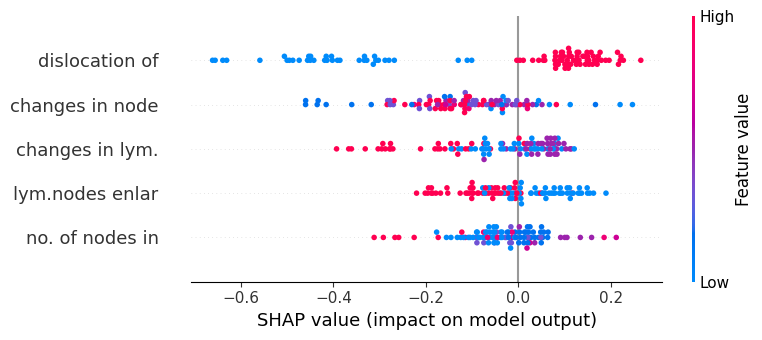

In [11]:

# Plot the feature importance
plot_factory = ShapPlotFeatures(shap_feature_selector) 
plot_factory.summary_plot()


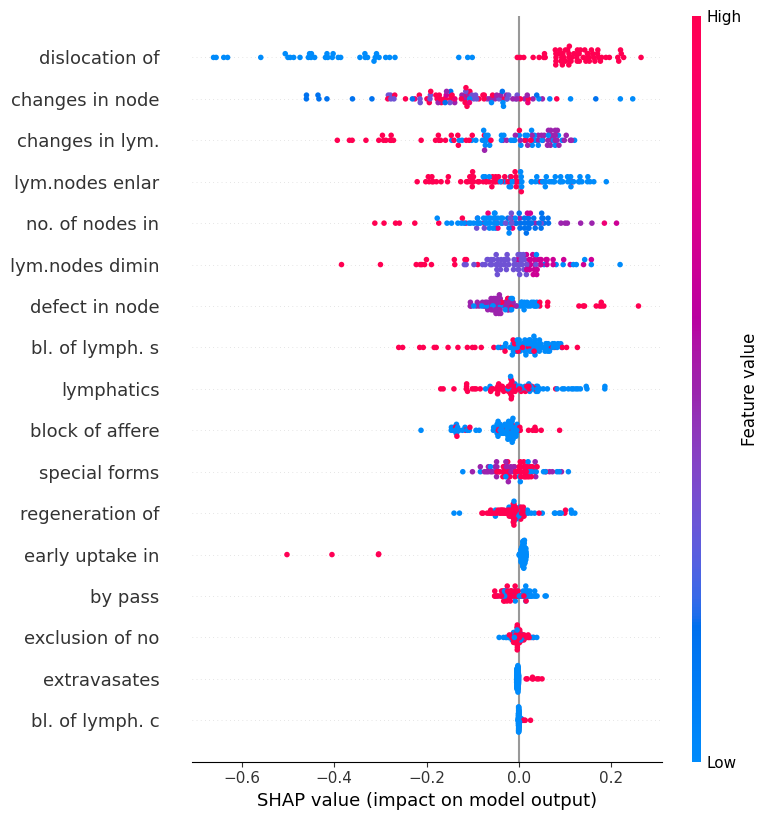

In [12]:
plot_factory.summary_plot_full()

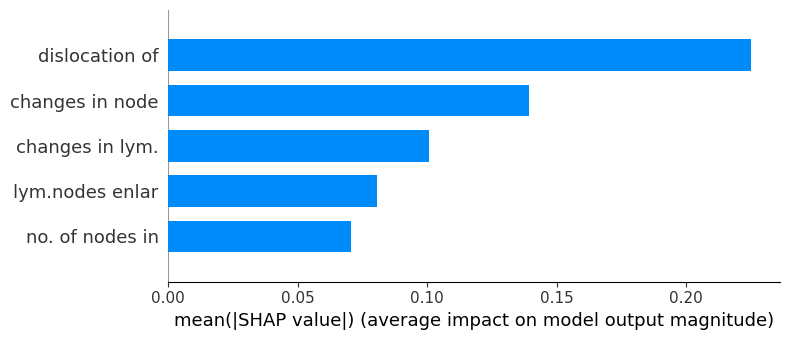

In [13]:

# Plot the feature importance
plot_factory.bar_plot()

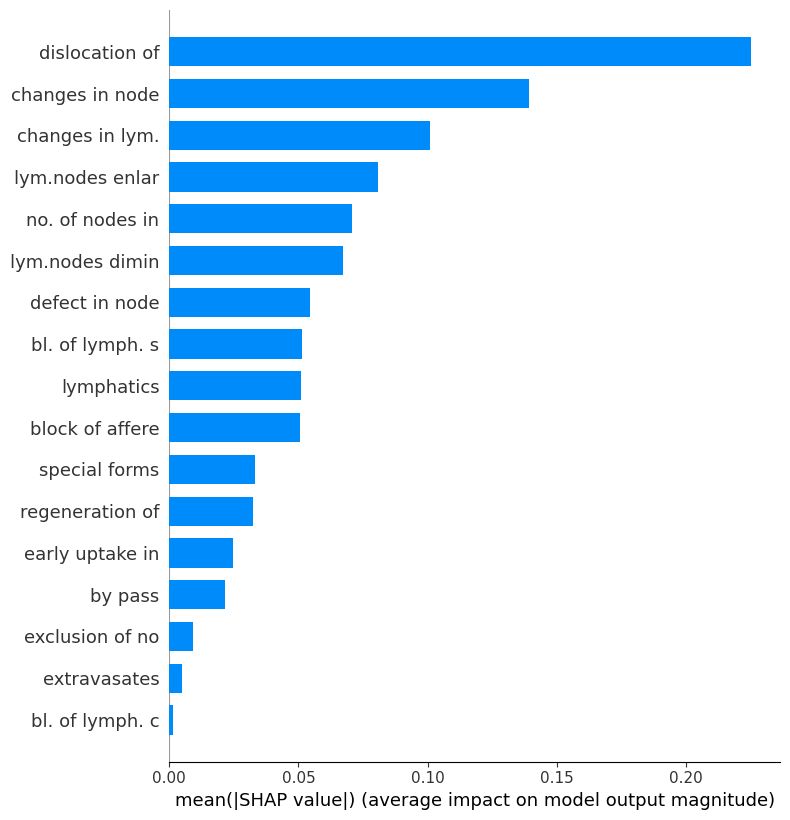

In [14]:
plot_factory.bar_plot_full()

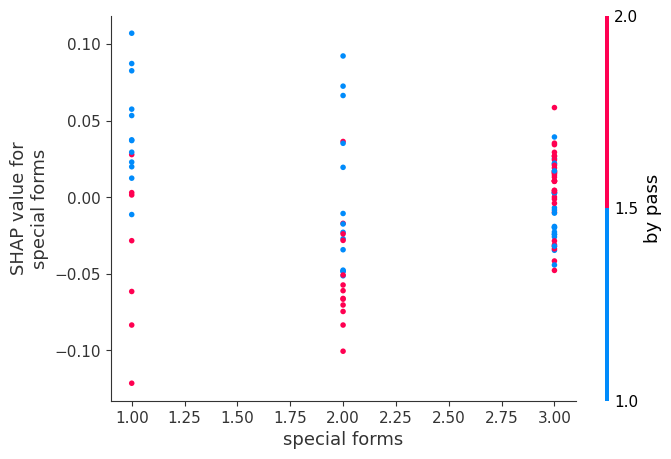

In [15]:
plot_factory.dependence_plot('special forms')

#### Feature importance data frame

In [16]:
feature_selection.importance_df

,Importance,Values
0,14,0.208519
1,12,0.169384
2,10,0.152647
3,0,0.127499
4,9,0.113690
5,11,0.109167
6,8,0.102964
7,15,0.096004
8,6,0.067196
9,16,0.062528


In [17]:
# name of features
X_train.columns

Index(['lymphatics', 'block of affere', 'bl. of lymph. c', 'bl. of lymph. s',
       'by pass', 'extravasates', 'regeneration of', 'early uptake in',
       'lym.nodes dimin', 'lym.nodes enlar', 'changes in lym.',
       'defect in node', 'changes in node', 'special forms', 'dislocation of',
       'exclusion of no', 'no. of nodes in'],
      dtype='object')